<a href="https://colab.research.google.com/github/keeratkaurbhatia/Melanoma-vs-Nevus/blob/main/melanoma_vs_nevi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

In [ ]:
# Upload your kaggle.json file
from google.colab import files
files.upload()  # Upload kaggle.json when prompted
import os
import zipfile

# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download HAM10000 dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip the dataset
with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", "r") as zip_ref:
    zip_ref.extractall("HAM10000_dataset")

# Check extracted contents
os.listdir("HAM10000_dataset")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [02:03<00:00, 123MB/s]
100% 5.20G/5.20G [02:03<00:00, 45.3MB/s]


['hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_1',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'ham10000_images_part_2']

In [ ]:
import shutil

# Create a central folder for all images
os.makedirs("HAM10000_images", exist_ok=True)

# Move images from both parts
shutil.move("HAM10000_dataset/HAM10000_images_part_1", "HAM10000_images_part_1")
shutil.move("HAM10000_dataset/HAM10000_images_part_2", "HAM10000_images_part_2")

# Merge both parts into one folder
for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    for img in os.listdir(folder):
        shutil.move(os.path.join(folder, img), "HAM10000_images")

# Clean up
shutil.rmtree("HAM10000_images_part_1")
shutil.rmtree("HAM10000_images_part_2")


In [3]:

# Load metadata
df = pd.read_csv("HAM10000_dataset/HAM10000_metadata.csv")  # Adjusted path

# Filter for only Melanoma and Nevi
df = df[df["dx"].isin(["mel", "nv"])].reset_index(drop=True)
df["label"] = df["dx"].map({"mel": 0, "nv": 1})  # Binary labels

# Construct full image path
df["path"] = df["image_id"].apply(lambda x: os.path.join("HAM10000_images", f"{x}.jpg"))

# Split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    df["path"].values,
    df["label"].values,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Second split: val and test from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,  # 10% of total = 50% of the remaining 20%
    stratify=temp_labels,
    random_state=42
)
from sklearn.utils import class_weight
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print to verify
print("Class distribution in training set:")
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

print("\nClass weights:")
print(class_weights)


Class distribution in training set:
{np.int64(0): np.int64(890), np.int64(1): np.int64(5364)}

Class weights:
{0: np.float64(3.513483146067416), 1: np.float64(0.5829604772557793)}


In [4]:
def gamma_correction(image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    return tf.pow(image, inv_gamma)

def contrast_stretching(image):
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    return (image - min_val) / (max_val - min_val + 1e-8)

def tf_preprocess_pipeline(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0, 1]

    image = gamma_correction(image)
    image = contrast_stretching(image)
    image = tf.image.resize(image, IMAGE_SIZE)

    return image


In [5]:
def create_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda path, label: (tf_preprocess_pipeline(path), label), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_dataset = create_dataset(train_paths, train_labels)
val_dataset = create_dataset(val_paths, val_labels)
test_dataset = create_dataset(test_paths, test_labels)


In [ ]:
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for now

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 171s 875ms/step - accuracy: 0.5039 - loss: 0.7026 - val_accuracy: 0.8542 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 144s 736ms/step - accuracy: 0.5261 - loss: 0.6995 - val_accuracy: 0.8529 - val_loss: 0.6302 - learning_rate: 0.0010
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 150s 764ms/step - accuracy: 0.5364 - loss: 0.7029 - val_accuracy: 0.8427 - val_loss: 0.6363 - learning_rate: 0.0010
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 149s 762ms/step - accuracy: 0.5209 - loss: 0.7014 - val_accuracy: 0.8427 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 151s 767ms/step - accuracy: 0.5522 - loss: 0.6978 - val_accuracy: 0.8312 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 150s 765ms/step - accuracy: 0.5308 - loss: 0.7016 - val_accuracy: 0.8299 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 146s 747ms/step - accura

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_finetune = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

callbacks_finetune = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2),
    checkpoint_finetune
]

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=callbacks_finetune,
    initial_epoch=history.epoch[-1], #to continue the epoch count from where stage 1 left off
    class_weight=class_weights
)


Epoch 9/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4672 - loss: 0.6544   
Epoch 9: val_accuracy improved from -inf to 0.85550, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.4676 - loss: 0.6541 - val_accuracy: 0.8555 - val_loss: 0.5399 - learning_rate: 1.0000e-05
Epoch 10/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.6818 - loss: 0.4722
Epoch 10: val_accuracy did not improve from 0.85550
196/196 ━━━━━━━━━━━━━━━━━━━━ 192s 810ms/step - accuracy: 0.6819 - loss: 0.4721 - val_accuracy: 0.8529 - val_loss: 0.5169 - learning_rate: 1.0000e-05
Epoch 11/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7664 - loss: 0.3922
Epoch 11: val_accuracy improved from 0.85550 to 0.85934, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 217s 963ms/step - accuracy: 0.7664 - loss: 0.3922 - val_accuracy: 0.8593 - val_loss: 0.3909 - learning_rate: 1.0000e-05
Epoch 12/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accur

Loading best model from checkpoint...
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 835ms/step - accuracy: 0.8919 - loss: 0.2501

Test Loss: 0.2476
Test Accuracy: 0.8887

ROC AUC Score: 0.9291
Optimal Threshold (ROC): 0.7661
Optimal Threshold (F1): 0.2671

Classification Report:
              precision    recall  f1-score   support

Melanoma (0)       0.82      0.56      0.66       111
    Nevi (1)       0.93      0.98      0.95       671

    accuracy                           0.92       782
   macro avg       0.87      0.77      0.81       782
weighted avg       0.91      0.92      0.91       782



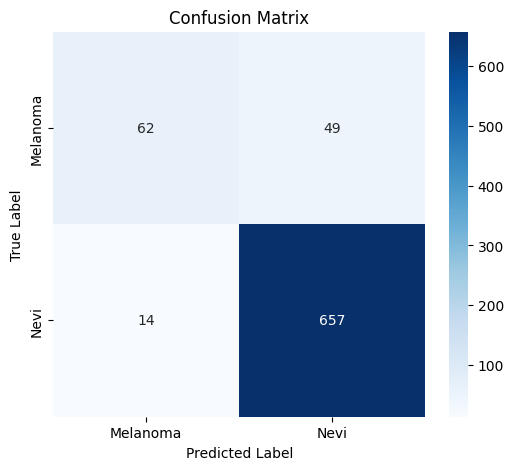

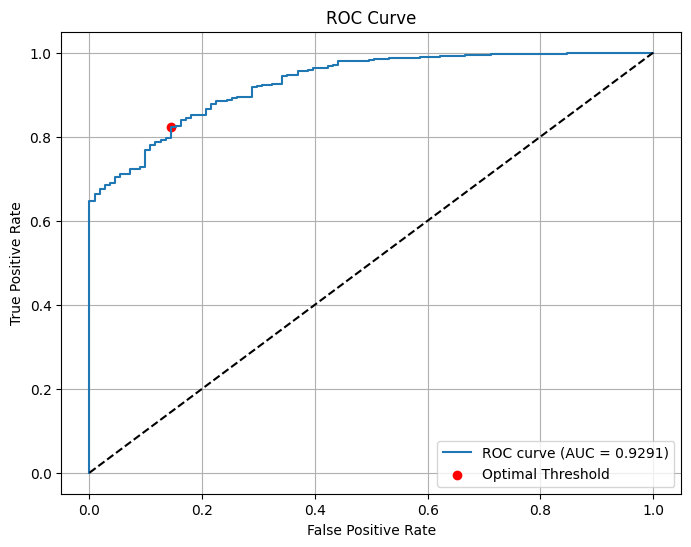

In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
print("Loading best model from checkpoint...")
model = load_model("best_model.keras")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test set
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    probs = model.predict(images, verbose=0)
    y_pred_probs.extend(probs.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (ROC): {optimal_threshold:.4f}")

# You can optionally try F1-optimal threshold
f1_scores = [f1_score(y_true, y_pred_probs > thr) for thr in thresholds]
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
print(f"Optimal Threshold (F1): {f1_optimal_threshold:.4f}")

# Convert probabilities to predictions using selected threshold
y_pred = (y_pred_probs > f1_optimal_threshold).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Melanoma (0)", "Nevi (1)"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Melanoma", "Nevi"], yticklabels=["Melanoma", "Nevi"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label="Optimal Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
